In [1]:
import Model
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
#from tensorflow.keras.models import Model
from tqdm import tqdm 
import time
import os
import re
import hashlib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
#import SpeechGenerator
import librosa
import DataGeneration as dg
#from keras import losses
import python_speech_features as sf

from extractMFCC import computeFeatures, computeFeatures1
from addNoise import addNoise

tf.enable_eager_execution()
print(tf.executing_eagerly())
print(tf.__version__)
print(tf.keras.__version__)

Using TensorFlow backend.


True
1.14.0
2.2.4-tf


In [2]:
dataset_dir = "Dataset/"

val_file = 'validation_list.txt'
test_file = 'testing_list.txt'

# Dictionary containing the mapping between category name and label
DictCategs = {'nine' : 1, 'yes' : 2, 'no' : 3, 'up' : 4, 'down' : 5, 'left' : 6, 'right' : 7, 'on' : 8, 'off' : 9, 
              'stop' : 10, 'go' : 11, 'zero' : 12, 'one' : 13, 'two' : 14, 'three' : 15, 'four' : 16, 'five' : 17, 
              'six' : 18, 'seven' : 19, 'eight' : 20, 'backward':21, 'bed':22, 'bird':23, 'cat':24, 'dog':25, 'follow':26, 
              'forward':27, 'happy':28, 'house':29, 'learn':30, 'marvin':31, 'sheila':32, 'tree':33, 'visual':34, 'wow':0,
              '_background_noise_':0 }
nCategs = 35

data = dg.DataGeneration(dataset_dir, DictCategs, nCategs)
train, trainLabels, val, valLabels, test, testLabels = data.create_data(test_file, val_file)

Loading of the train set:
0/84843
5000/84843
10000/84843
15000/84843
20000/84843
25000/84843
30000/84843
35000/84843
40000/84843
45000/84843
50000/84843
55000/84843
60000/84843
65000/84843
70000/84843
75000/84843
80000/84843
84843/84843
Loading of the validation set:
0/9981
5000/9981
9981/9981
Loading of the test set:
0/11005
5000/11005
10000/11005
11005/11005


File: one/85ac0c1b_nohash_0.wav.npy - Label: 13


Text(0.5, 1.0, 'WAV signal')

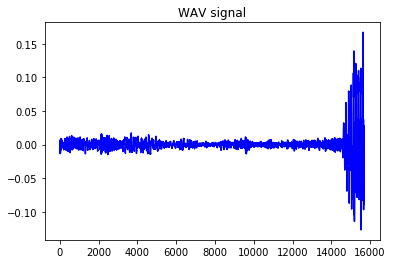

In [3]:
index = 2345
print("File: " + train[index] + " - Label: " + str(trainLabels[index]))

# Plot a wav
file_name = train[index]
wav = dg.DataGeneration.load_data(dataset_dir, file_name)

plt.figure()
plt.plot(wav, color='b')
plt.title('WAV signal')

(100, 80)


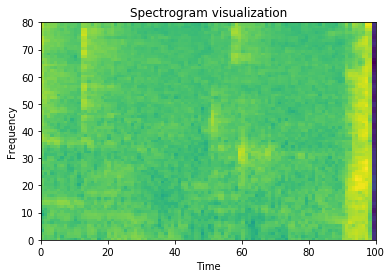

[[ 0.22008191 -0.04291138  0.15084353 ...  1.9797534   1.1381433
  -7.23392   ]
 [ 0.45325646  0.03715846  0.24108128 ...  2.0635843   0.8162636
  -7.1348953 ]
 [ 0.16548125  0.3283307   0.5486094  ...  1.9359474   0.53671086
  -7.0534906 ]
 ...
 [ 1.278654    0.8532615   0.8950775  ...  1.855       1.939469
  -7.329352  ]
 [ 1.6972997   1.0294385   1.1188984  ...  2.5447295   2.5328712
  -7.342661  ]
 [ 1.7886903   0.7663632   0.99164027 ...  2.9080763   2.8587806
  -7.0617695 ]]


In [4]:
feats = dg.DataGeneration.load_and_preprocess_data(dataset_dir, train[index], False)
print(feats.shape)
feats = np.transpose(feats)
plt.figure()
plt.pcolormesh(feats)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()
print(feats)

In [5]:
batch_size = 256

train_dataset = dg.DataGeneration.create_dataset(dataset_dir, train, trainLabels, 
                                                 batch_size = batch_size, 
                                                 shuffle = True, 
                                                 cache_file = 'train_cache_Attention_35class')

val_dataset = dg.DataGeneration.create_dataset(dataset_dir, val, valLabels, 
                                               batch_size = batch_size, 
                                               shuffle = False, 
                                               cache_file = 'val_cache_Attention_35class')

test_dataset = dg.DataGeneration.create_dataset(dataset_dir, test, testLabels, 
                                                batch_size = batch_size, 
                                                shuffle = False, 
                                                cache_file = 'test_cache_Attention_35class')

train_steps = int(np.ceil(len(train) / batch_size))
val_steps = int(np.ceil(len(val) / batch_size))
test_steps = int(np.ceil(len(test) / batch_size))

print("steps to completa a train epoch: " + str(train_steps))
print("steps to completa a validation spoch: " + str(val_steps))
print("steps to completa a test epoch: " + str(test_steps))

steps to completa a train epoch: 332
steps to completa a validation spoch: 39
steps to completa a test epoch: 43


# Inizio modelli! Attention classico

In [ ]:
model = Model.AttentionModelSimplified1(nCategs, 100, 80, 32, use_GRU = True, dropout = 0.4, activation = 'relu')
model.summary()

In [ ]:
# questa funzione sembra essere difficile da applicare ad un fit normale, si può provare ma intanto ho provato ad usare 
# l'exp_decay che si da in ingresso all'optimizer
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 3.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AttentionModel-checkpoint-simplified.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001
global_step = tf.Variable(train_steps * 2, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, train_steps * 2,
                                        0.4, staircase = True)

adam = tf.train.AdamOptimizer(decayed_lr, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

#model.load_weights('Model/AttentionModel-checkpoint-1.h5')

In [ ]:
num_epochs = 5
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

In [ ]:
#print(history.history.keys())

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'], label = 'Train acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'Val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Save the model
model.save('Model/AttentionModel-1_00-0607-13-35class.h5')

testEval = model.evaluate(test_dataset,
                          steps = test_steps,
                          verbose = 1)

In [ ]:
x = "left/94de6a6a_nohash_2.wav.npy"
x = load_and_preprocess_data(x, dataset_dir).reshape((1, 100, 80, 1))
print(x.shape)
res = model.predict(x) 
print(res.argmax())

# Prova versione semplificata 2

In [ ]:
model2 = Model.AttentionModelSimplified2(nCategs, 100, 80, 32, use_GRU = True, dropout = 0.4, activation = 'relu')
model2.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AttentionModel-checkpoint-simplified-2.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001
global_step = tf.Variable(train_steps * 2, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, train_steps * 2,
                                        0.4, staircase = True)

adam = tf.train.AdamOptimizer(decayed_lr, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model2.compile(optimizer = 'adam',
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

#model.load_weights('Model/AttentionModel-checkpoint-1.h5')

In [ ]:
num_epochs = 10
history = model2.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

# Prova versione semplificata 3

In [ ]:
model = Model.AttentionModelSimplified3(nCategs, 100, 80, 32, use_GRU = True, dropout = 0.1, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AttentionModel-checkpoint-simplified-3.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001
global_step = tf.Variable(train_steps * 2, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, train_steps * 2,
                                        0.4, staircase = True)

adam = tf.train.AdamOptimizer(decayed_lr, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

#model.load_weights('Model/AttentionModel-checkpoint-1.h5')

In [ ]:
num_epochs = 10
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

# Prova versione semplificata 4

Un solo convoluzionale 7x7 con una gru, con anche attention.   
Dropout 25%.  
Training accuracy 72%  
Test accuracy 67,5%  
Bloccato dopo 8 epoche per fine ram, per ora il migliore. Stava ancora salendo.

In [ ]:
model = Model.AttentionModelSimplified4(nCategs, 100, 80, 32, use_GRU = True, dropout = 0.25, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AttentionModel-checkpoint-simplified-4.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001
global_step = tf.Variable(train_steps * 2, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, train_steps * 2,
                                        0.4, staircase = True)

adam = tf.train.AdamOptimizer(decayed_lr, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

model.load_weights('Model/AttentionModel-checkpoint-simplified-4.h5')

In [ ]:
num_epochs = 10
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

# Prova versione semplificata 5

Convoluzionali più spinti, solo però con un kernel, e max pooling in frequenza. GRU. ATTENTION.   
Probabilmente la rete è troppo piccola! Dropout 25%.  
Training accuracy: 42%  
VAlidation accuracy: 18%  
Fatte 3 epoche.  

In [ ]:
model = Model.AttentionModelSimplified5(nCategs, 100, 80, 16, use_GRU = True, dropout = 0.25, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AttentionModel-checkpoint-simplified-5.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001
global_step = tf.Variable(train_steps * 2, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, train_steps * 2,
                                        0.4, staircase = True)

adam = tf.train.AdamOptimizer(decayed_lr, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

#model.load_weights('Model/AttentionModel-checkpoint-5.h5')

In [ ]:
num_epochs = 10
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

# Prova versione semplificata 6

Versione migliorata della 4. 2 Convoluzionali e max pooling in frequenza. 2 Gru perchè se no mi riduceva troppo i parametri il max pooling e  attention.  
oVerfitta anche questo: Train 66 Test 14

In [ ]:
model = Model.AttentionModelSimplified6(nCategs, 100, 80, 32, use_GRU = True, dropout = 0.25, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AttentionModel-checkpoint-simplified-6.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001
global_step = tf.Variable(train_steps * 2, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, train_steps * 2,
                                        0.4, staircase = True)

adam = tf.train.AdamOptimizer(decayed_lr, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

#model.load_weights('Model/AttentionModel-checkpoint-6.h5')

In [ ]:
num_epochs = 10
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

# Prova versione semplificata 7

Versione migliorata della 4 e 6. Aggiunti più attention layer (0, 49, 99).  
Prove seguenti con dropout 40%.  
Versione con 2 gru overfittato -> training 51 / validation 3 (3 epoche)  
Tolto un gru proviamo -> overfittin training 49 /validation 8 3 epoche poi bloccato!

In [ ]:
model = Model.AttentionModelSimplified7(nCategs, 100, 80, 32, use_GRU = True, dropout = 0.4, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AttentionModel-checkpoint-simplified-7b.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001
global_step = tf.Variable(train_steps * 2, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, train_steps * 2,
                                        0.4, staircase = True)

adam = tf.train.AdamOptimizer(decayed_lr, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

#model.load_weights('Model/AttentionModel-checkpoint-7b.h5')

In [ ]:
num_epochs = 5
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

# Prova versione semplificata 8

Versione parallelizzata, con 3 gru e 3 attention!  
Prove seguenti con dropout: 0.3.  
Dopo 2 epoche e mezzo è crasciato! Train: 16 (bassa),  validation: 3 (magari era più alta alla fine della terza epoca però boh

In [ ]:
model = Model.AttentionModelSimplified8(nCategs, 100, 80, 64, use_GRU = True, dropout = 0.3, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AttentionModel-checkpoint-simplified-8.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001
global_step = tf.Variable(train_steps * 2, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, train_steps * 2,
                                        0.4, staircase = True)

adam = tf.train.AdamOptimizer(decayed_lr, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

#model.load_weights('Model/AttentionModel-checkpoint-8.h5')

In [ ]:
num_epochs = 5
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

# Prova versione semplificata 9
## Versione di douglas usando però lo stato finale della gru

Primo test: (con troppe cnn)  
Dropout: 0.4  
Overfitting -> Train 40 - Test 3.5

Secondo test più corretto per comparare:  
Dropout 0.4  
Overfitting -> Train 53 - Test 05  

Terzo Tentativo: Tolta una gru e oggiungiamo un sacco di regolarizzazzione!  
Problema: Dopo due epoche non ha imparato niente!  

Quarto: Ridotta un po la regolarizzazzione!  
Problema: Dopo due epoche non ha ancora imparato niente!

Quinto tentativo: Ridotto un po' il dropout che era stato aumentato molto! (i lavello di layer)!  
Problema: Non impara ancora niente....

Sesto tentativo: Aggiunto un convoluzionale in più, cambiato la regolarizzazzione da l1 a l2  
Overfittato male -> train 56 - test 6

Settimo: maggior regolarizzazzione l2  
Ovefitting ma solo dopo la terza epoca 

Ottavo tentativo: L2 a 0.25, Drop 0.4, aggiunto più kernel al cnn, messo l1 0.001  
Overfitting: Train 35 test 10

Nono tentativo: L2 0.5, drop 0.4, l1 0.0, messo tutto relu!   
Overfitting -> train 35 - test 4

DEcimo tentativo: Ridotta la grednezza della rete (64 - 48), Drop 0.3, aumentata la batch a 256!  
overfitting -> train 50 - test 10 (arrivato fino pero alla 4 epoca)  

11 tent: cambiato inizializer di gru! Drop 0.4! Reg l2 0.2.  
overfitting -> train 26 - test 3

12: Drop 0.4! l2 0.3 aggiunto sul bias l2 0.01! Tolto un cnn!  
Non ha imparato niente 5 epoche per train 9 e test 4!  

13: Drop 0.4, l2 0.25, bias l2 0.001.  
Forse non stava overffittando ma alla fine della 4 epoca eravamo ancora train 8 val 6.5  

14: Drop 0.4. Aggiunto drop anche tra convoluzionali (0.2) e in input (0.1). Rimessa la convoluzionale tolta. Regolarizzazzione non modificata. 
Non ha overfittato fino alla 9 epoca -> train 46 test 37 -> overfitting train 47 test 16  

15: Drop 0.4 anche ai livelli convoluzionali! Drop sull'input aumentato a 0.15! Regolarizzazzione l2 messa 0.1 bias non mod (0.001)  
Overfitting train 20 val 4  

16: Drop 0.4, conv drop 0.25, drop input 0.1, l2 0.15, l2 bias 0.001, aggiunti due kernel al primo conv (3 -> 5)  
Overfittin terza epoca train 21 val 3.8  

17: Drop 0.4, conv drop 0.25, drop input 0.1, l2 0.2, l2 bias 0.001  
Overfitting 3 epoce train 26 - val 5,5  

18: Reduce the L2 from 0.2 to 0.05  
Overfittato dopo 8 epoche train 55 test 27 (scendendo verso il 18)

19: drop input: 0.05, drop conv 0.3, conv da 5 a 10   
Overfitting train 26 test 3 (3 epoche)  

20: drop input: 0.1, drop conv 0.25, conv da 10 a 5, l2 a 0.1, 64 unita  
dopo 5 epoche train 42 - test 25 -> fine decima epoca train 55 - test 47 -> forse inizio overfitting 11 epoca (train 57 -test 42) 
Overfittato e stop training alla 15 epoca train 60 - test 44 ma non cresceva più  

21: drop input 0.1, drop conv 0.3, 0.25, filtri conv 5 -> 10, l2 a 0.05, 64 unita  


In [6]:
model = Model.AttentionModelSimplified9(nCategs, 100, 80, 64, use_GRU = True, dropout = 0.4, activation = 'relu')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100, 80, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 80, 10)  500         dropout[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 80, 10)  40          conv2d[0][0]                     
______________________________________________________________________________________________

In [7]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AttentionModel-checkpoint-simplified-9.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [9]:
learning_rate = 0.001
global_step = tf.Variable(train_steps * 2, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, train_steps * 2,
                                        0.4, staircase = True)

adam = tf.train.AdamOptimizer(learning_rate, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

#model.load_weights('Model/AttentionModel-checkpoint-simplified-9.h5')

In [ ]:
num_epochs = 5
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

Epoch 1/5


W0712 10:22:43.151851 139645709543168 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


163/332 [=============>................] - ETA: 8:39 - loss: 21.8830 - sparse_categorical_accuracy: 0.0379

In [ ]:
#model.save_weights('Model/AttentionModel-versione9-60-44.h5')

# Prova versione semplificata 10
## Versione di stackoverflow

Dropout: 0.4  
Overfittin -> train 44 - test 4

In [ ]:
model = Model.AttentionModelSimplified10(nCategs, 100, 80, 64, use_GRU = True, dropout = 0.4, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AttentionModel-checkpoint-simplified-8.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001
global_step = tf.Variable(train_steps * 2, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, train_steps * 2,
                                        0.4, staircase = True)

adam = tf.train.AdamOptimizer(decayed_lr, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

#model.load_weights('Model/AttentionModel-checkpoint-8.h5')

In [ ]:
num_epochs = 5
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

# Prova versione semplificata 11
## Mia versione

Dropout: 0.4:  
Overfitting: Train 27 - Test 3.5 (un epoca)

In [ ]:
model = Model.AttentionModelSimplified11(nCategs, 100, 80, 64, use_GRU = True, dropout = 0.4, activation = 'relu')
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AttentionModel-checkpoint-simplified-8.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [ ]:
learning_rate = 0.001
global_step = tf.Variable(train_steps * 2, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, train_steps * 2,
                                        0.4, staircase = True)

adam = tf.train.AdamOptimizer(decayed_lr, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

#model.load_weights('Model/AttentionModel-checkpoint-8.h5')

In [ ]:
num_epochs = 5
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])